In [33]:
# Importing required module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dc_stat_think as dcst
from datetime import timedelta
import pandasql as ps
import os
import warnings;warnings.filterwarnings('ignore');

os.chdir('C:\\Users\\Ravi\\Downloads\\xchange')

In [53]:
# Request Data .. start of conversation
request_df = pd.read_csv("T_REQUEST.csv",sep=",",parse_dates=['created_date','last_modified_date'])


request_df['created_date'] = request_df['created_date'].apply(lambda x:x.date())
print('Number of unique request ids :',request_df.id.nunique())


cols = ['id','created_date']
# request_df = request_df[cols]
request_df.head()

Number of unique request ids : 96786


,id,created_by,created_date,last_modified_by,last_modified_date,carrier_on_turn_id,emails_deactivated,manual_request,requesters_agent_msg,addressees_agent_msg,...,assisted_transaction,insurance_payer,active_matchmaking,insurance_only,critical,leasing,prepayment_of_charge,no_payment_guarantee,grey_zone_agreed,has_damage_claim
0,1,ulrich.bartels@hamburgsud.com,2015-06-30,system,2016-01-25 23:00:00,NaN,0,0,NaN,NaN,...,0,NaN,1,0,0,0,0,0,0,0
1,2,malini.k@uasc.net,2015-07-06,system,2016-01-25 23:00:00,NaN,0,0,NaN,NaN,...,0,NaN,1,0,0,0,0,0,0,0
2,3,tpartridge@triu.com,2015-08-05,system,2016-01-25 23:00:00,NaN,0,0,NaN,NaN,...,0,NaN,1,0,0,0,0,0,0,0
3,4,tpartridge@triu.com,2015-08-11,tpartridge@triu.com,2015-08-11 04:28:00,NaN,0,0,NaN,NaN,...,0,NaN,1,0,0,0,0,0,0,0
4,5,tpartridge@triu.com,2015-08-12,system,2016-01-25 23:00:00,NaN,0,0,NaN,NaN,...,0,NaN,1,0,0,0,0,0,0,0


In [42]:
# changes in conversation
version_df = pd.read_csv("T_REQUEST_VERSION.csv",sep=",",parse_dates=['last_modified_date'])

version_df['last_modified_date'] = version_df['last_modified_date'].apply(lambda x:x.date())

version_col = ['requester_id', 'addressee_id','request_id', 'last_modified_date','version', 'status']
version_df = version_df[version_col]
version_df.sort_values(by =['request_id','last_modified_date'], axis=0, ascending=[True,True], inplace= True)

print('Number of unique request ids : ',version_df.request_id.nunique())
print('Number of unique addressee ids : ',version_df.addressee_id.nunique())
print('Number of unique requester id : ',version_df.requester_id.nunique())
print('\nStatus Numbers :\n' ,version_df.status.value_counts())


status_dict ={"IN_PROGRESS":-1,"CONFIRMED":-1,"CANCELLED":0, "ACCEPTED":1, 
              "EMPTY_RETURNED":2,"PICKED_UP":2, "READY_FOR_PICKUP":2 } 

version_df.replace({"status": status_dict},inplace = True)
print('\nStatus Numbers :\n' ,version_df.status.value_counts())
version_df = version_df[~version_df['status'].isin([-1,2])]

version_df.head(10)

Number of unique request ids :  96797
Number of unique addressee ids :  770
Number of unique requester id :  665

Status Numbers :
 IN_PROGRESS         130441
CANCELLED            87293
ACCEPTED             11618
EMPTY_RETURNED        7572
CONFIRMED             6789
PICKED_UP             6671
READY_FOR_PICKUP      6618
Name: status, dtype: int64

Status Numbers :
 -1    137230
 0     87293
 2     20861
 1     11618
Name: status, dtype: int64


,requester_id,addressee_id,request_id,last_modified_date,version,status
223,11,7,1,2016-01-25,4,0
224,7,2,2,2016-01-25,2,0
225,13,2,3,2016-01-25,2,0
39,13,7,4,2015-10-20,2,0
226,13,2,5,2016-01-25,2,0
227,13,2,6,2016-01-25,2,0
38,13,7,7,2015-10-20,2,0
10,13,11,8,2015-08-12,2,0
17,13,8,9,2015-10-14,2,0
18,13,8,10,2015-10-14,2,0


In [44]:
request_df.rename(columns={'id':'request_id'}, inplace=True)

version_df.rename(columns={'last_modified_date': 'end_date', 'status': 'result','version':'stages'}, inplace=True)
version_df.head()


result_df = pd.merge(request_df,version_df,on = 'request_id')
result_df.sort_values(by =['addressee_id','request_id'],ascending=[True,True], inplace= True, axis=0)
result_df.drop_duplicates(subset= result_df.columns.difference(['request_id']), inplace = True)


result_df['duration'] =  result_df['end_date'] - result_df['created_date']
result_df['duration'] = result_df['duration'].apply(lambda x : x.days)
# result_df['duration']=result_df['duration']/np.timedelta64(1,'h')



# result_df['request_gap'] = result_df['created_date'] - result_df.groupby(['addressee_id'])['created_date'].shift()
# result_df['request_gap'] = result_df['request_gap'].apply(lambda x : x.days)
# result_df['request_gap'].fillna(0, inplace=True)


result_df['activity_start_date'] = result_df['end_date']- timedelta(days=7)
success_df = result_df[result_df.result == 1]

print(result_df['result'].value_counts())
result_df.head(30)

0    78260
1     7560
Name: result, dtype: int64


,request_id,created_date,requester_id,addressee_id,end_date,stages,result,duration,activity_start_date
45884,47791,2019-04-05,549,1,2019-04-05,2,1,0,2019-03-29
53546,55477,2019-06-20,549,1,2019-06-20,2,1,0,2019-06-13
54966,56892,2019-07-02,549,1,2019-07-02,2,1,0,2019-06-25
57200,59102,2019-07-24,549,1,2019-07-24,2,1,0,2019-07-17
58981,60952,2019-08-13,549,1,2019-08-13,2,1,0,2019-08-06
60326,62269,2019-08-28,549,1,2019-08-28,2,1,0,2019-08-21
61204,63111,2019-09-12,549,1,2019-09-12,2,1,0,2019-09-05
63839,65660,2019-10-21,549,1,2019-10-21,2,1,0,2019-10-14
66552,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13
69167,70849,2019-12-24,549,1,2019-12-24,2,1,0,2019-12-17


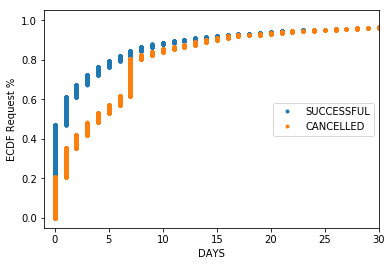

In [47]:
# x,y = dcst.ecdf(result_df[result_df.request_gap != 0]['request_gap'])
# plt.plot(x,y,marker ='.', linestyle='none')

x1,y1 = dcst.ecdf(result_df[result_df.result == 1]['duration'])
x2,y2 = dcst.ecdf(result_df[result_df.result == 0]['duration'])

# # plotting ECDF
plt.plot(x1,y1,marker ='.', linestyle='none')
plt.plot(x2,y2,marker ='.', linestyle='none')


plt.xlabel('DAYS')
plt.ylabel('ECDF Request %')
plt.legend(['SUCCESSFUL','CANCELLED'], loc = 5)
plt.xlim([-1,30])
plt.show()

In [50]:
tracking_df = pd.read_csv("T_USER_TRACKING.csv",sep=",",parse_dates=['created_date'])
tracking_df.rename(columns={'created_date': 'event_date'}, inplace=True)
tracking_df['event_date'] = tracking_df['event_date'].apply(lambda x:x.date())
cols =['company_id','event_date','event']
# tracking_df = tracking_df[cols]
tracking_df.sort_values(by =['company_id','event_date'], axis=0, ascending=[True,True], inplace= True)

print('Number of records :',tracking_df.shape[0])
print('Number of Addressee ids :',tracking_df.company_id.nunique())
tracking_df.head()

Number of records : 1658341
Number of Addressee ids : 1064


,id,event,additional_info,user_id,impersonated,event_date,company_id
29285,29428,View Tracking Page,NaN,620,0,2018-07-09,1
29286,29429,View Tracking Page,NaN,620,0,2018-07-09,1
29287,29430,View Tracking Page,NaN,620,0,2018-07-09,1
29307,29450,View Request Details,Request Id: 16409,620,0,2018-07-09,1
29598,29741,View Request Details,Request Id: 22924,620,0,2018-07-09,1


In [20]:
query = '''
            SELECT r.*,t.*
            FROM success_df r
            INNER JOIN tracking_df t
            ON r.addressee_id = t.company_id AND 
               t.event_date BETWEEN r.activity_start_date AND  r.end_date
            
        '''

activity_df = ps.sqldf(query,locals())
print(activity_df.shape[0])
activity_df.head()

1416512


,request_id,created_date,requester_id,addressee_id,end_date,stages,result,duration,activity_start_date,company_id,event_date,event
0,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,Login
1,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,Login
2,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
3,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
4,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details


In [49]:
activity_df.head(30)

,request_id,created_date,requester_id,addressee_id,end_date,stages,result,duration,activity_start_date,company_id,event_date,event
0,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,Login
1,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,Login
2,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
3,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
4,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
5,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
6,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
7,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
8,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details
9,68298,2019-11-20,549,1,2019-11-20,2,1,0,2019-11-13,1,2019-11-15,View Request Details


In [52]:
print('Number of success :',success_df.shape[0])
long_df = activity_df.groupby(['request_id', 'event']).size().reset_index(name='counts')

names ={'View Request Details':'Details',
        'Get All Requests':'All',
        'Send Request':'Send',
        'Reject Request':'Reject',
        'Accept Request':'Accept',
        'Get Newsfeed For Dashboard':'Newsfeed',
        'Update Request':'Update',
        'Visit company profile':'Visit',
        'Get Requests For Dashboard':'Requests',
        'View Balance Overview':'View_Balance',
        'Get Requests For Request Overview for status: ACTION_REQUIRED':'Request_status',
        'Get Requests For Request Overview':'Get_Request_Overview',
        'Balance update':'Balance',
        'View Tracking Page':'Tracking_Page',
        'Request Overview':'Request_Overview'
        }


print(long_df['event'].value_counts())
wide_df = long.pivot(index='request_id', columns='event', values='counts')
wide_df.rename(columns=names,inplace=True)


wide_df.head()

Number of success : 7560
View Request Details                                             5082
Get All Requests                                                 4846
Send Request                                                     4252
Reject Request                                                   4174
Accept Request                                                   4028
Get Newsfeed For Dashboard                                       2943
Login                                                            2938
Update Request                                                   2555
Visit company profile                                            1301
Get Requests For Dashboard                                        314
View Balance Overview                                             187
Get Requests For Request Overview for status: ACTION_REQUIRED      69
Get Requests For Request Overview                                  66
Balance update                                                   

event,Accept,Balance,All,Newsfeed,Requests,Get_Request_Overview,Request_status,Login,Reject,Request_Overview,Send,Update,View_Balance,Details,Tracking_Page,Visit
request_id,,,,,,,,,,,,,,,,
7885,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,12.0,NaN,NaN
9849,NaN,NaN,NaN,NaN,30.0,36.0,NaN,NaN,NaN,NaN,6.0,NaN,30.0,36.0,NaN,NaN
9858,NaN,NaN,NaN,NaN,10.0,12.0,NaN,NaN,NaN,NaN,2.0,NaN,10.0,12.0,NaN,NaN
12805,NaN,NaN,NaN,NaN,5.0,6.0,NaN,NaN,NaN,NaN,1.0,NaN,5.0,6.0,NaN,NaN
13499,NaN,NaN,NaN,NaN,31.0,24.0,1.0,2.0,1.0,NaN,4.0,NaN,1.0,46.0,NaN,NaN
